In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

import json
import pickle
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, StratifiedKFold
pd.set_option('max_columns', None)

def save_obj(obj, name):
    with open('./Data/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open('./Data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [2]:
data = load_obj('matchdata_19_20')

In [3]:
df = pd.DataFrame(columns=['match_id','radiant_win','radiant1_hero_id','radiant2_hero_id','radiant3_hero_id','radiant4_hero_id','radiant5_hero_id','dire1_hero_id','dire2_hero_id','dire3_hero_id','dire4_hero_id','dire5_hero_id'])
for match in data:
    entry=[]
    entry.append(match["match_id"])
    entry.append(match["radiant_win"])
    for player in match["players"]:
        entry.append(player['hero_id'])
    df.loc[len(df)] = entry
save_obj(df,"cleaned_heroes_df")

In [4]:
# Working DF
df_loaded = load_obj("cleaned_heroes_df")

df_targets = df_loaded[['match_id','radiant_win']]
df_targets.set_index("match_id", inplace = True)
df_loaded.set_index("match_id", inplace = True)

print(f'Number of samples in cleaned df: {df_loaded.shape[0]}')
print(f'Number of columns in cleaned df: {df_loaded.shape[1]}')

for col in df_loaded.columns:
    if df_loaded[col].isnull().any():
        print(col, df_loaded[col].isnull().sum())

X = df_loaded.drop(columns=["radiant_win"])
y = df_loaded[["radiant_win"]]
# X.reset_index(drop=True, inplace=True)
# y.reset_index(drop=True, inplace=True)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=12)
print(f'Number of samples in train: {X_train.shape[0]}')
print(f'Number of columns in train: {X_train.shape[1]}')

print(f'Number of samples in test: {X_test.shape[0]}')
print(f'Number of columns in test: {X_test.shape[1]}')

Number of samples in cleaned df: 21402
Number of columns in cleaned df: 11
Number of samples in train: 17121
Number of columns in train: 10
Number of samples in test: 4281
Number of columns in test: 10


In [5]:
df_loaded

,radiant_win,radiant1_hero_id,radiant2_hero_id,radiant3_hero_id,radiant4_hero_id,radiant5_hero_id,dire1_hero_id,dire2_hero_id,dire3_hero_id,dire4_hero_id,dire5_hero_id
match_id,,,,,,,,,,,
5178214128,True,39,31,99,101,91,15,3,87,17,104
5178231277,False,86,19,58,20,89,26,47,57,87,12
5178251923,False,93,11,13,7,107,54,52,129,26,85
5178260622,False,106,20,70,102,5,86,46,83,98,63
5178285915,False,8,86,23,46,5,3,106,51,52,55
...,...,...,...,...,...,...,...,...,...,...,...
5765290836,False,27,103,78,95,23,96,44,86,126,51
5765362801,False,104,86,103,32,113,9,58,28,70,69
5765422316,False,100,90,129,12,74,104,107,85,65,10


# Descriptive Analysis

In [99]:
# Load heroes data list
df_hero_list = pd.read_json('Data/heroes.json').T

In [100]:
df_hero_names = df_hero_list[['id','localized_name']]
df_hero_names.set_index("id", inplace = True)


In [101]:
heroes_list = []

for index, row in X.iterrows():
    for x in row:
        heroes_list.append(x)
    
print('heroes list length: ', len(heroes_list))


df_heroes = pd.DataFrame(heroes_list)
picks = df_heroes[0].value_counts()

df_heroes = df_hero_names.join(picks, how = "outer")
df_heroes.columns = ['Hero Name', 'Number Picks']
df_heroes.fillna(0)

heroes list length:  214020


,Hero Name,Number Picks
1,Anti-Mage,1522.0
2,Axe,1247.0
3,Bane,1496.0
4,Bloodseeker,1523.0
5,Crystal Maiden,1677.0
...,...,...
121,Grimstroke,3737.0
123,Hoodwink,0.0
126,Void Spirit,4444.0
128,Snapfire,3673.0


In [ ]:
plt.hist(X_train['game_len'], bins=40, label='Train');
plt.hist(X_test['game_len'], bins=40, label='Test');
plt.title('Distribution of game time');
plt.legend();

<AxesSubplot:xlabel='Hero Name'>

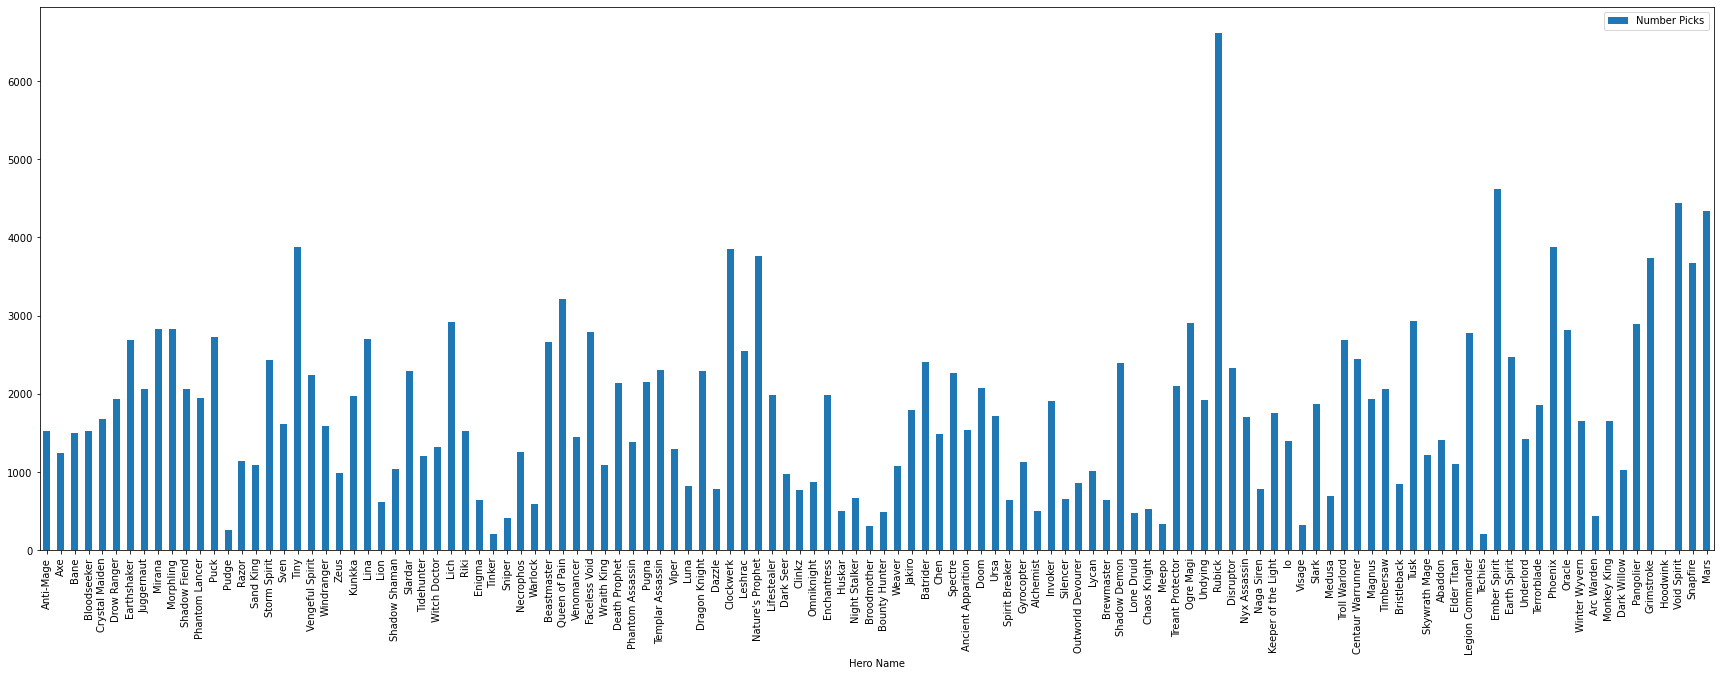

In [102]:
df_heroes.plot.bar(figsize=(30,10), x='Hero Name', y='Number Picks', rot=90)

In [104]:
df_heroes_sorted = df_heroes.sort_values(by=['Number Picks'])
smallest = df_heroes.nsmallest(10, 'Number Picks')
greatest = df_heroes.nlargest(10, 'Number Picks')

<AxesSubplot:xlabel='Hero Name'>

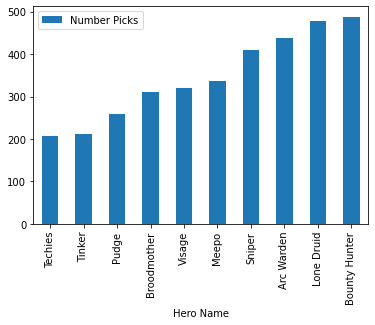

In [105]:
smallest.plot.bar(x='Hero Name', y='Number Picks', rot=90)

<AxesSubplot:xlabel='Hero Name'>

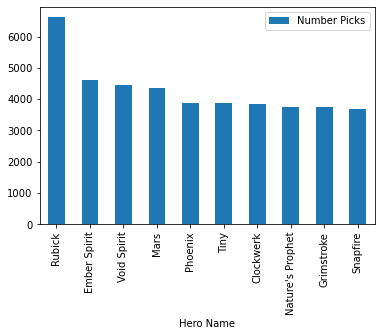

In [106]:
greatest.plot.bar(x='Hero Name', y='Number Picks', rot=90)

In [107]:
# Calculate Win rate per heroe
df_loaded

,radiant_win,radiant1_hero_id,radiant2_hero_id,radiant3_hero_id,radiant4_hero_id,radiant5_hero_id,dire1_hero_id,dire2_hero_id,dire3_hero_id,dire4_hero_id,dire5_hero_id
match_id,,,,,,,,,,,
5178214128,True,39,31,99,101,91,15,3,87,17,104
5178231277,False,86,19,58,20,89,26,47,57,87,12
5178251923,False,93,11,13,7,107,54,52,129,26,85
5178260622,False,106,20,70,102,5,86,46,83,98,63
5178285915,False,8,86,23,46,5,3,106,51,52,55
...,...,...,...,...,...,...,...,...,...,...,...
5765290836,False,27,103,78,95,23,96,44,86,126,51
5765362801,False,104,86,103,32,113,9,58,28,70,69
5765422316,False,100,90,129,12,74,104,107,85,65,10


In [108]:
test = df_loaded.iloc[0]
tes = test.iloc[1:6].values
tes

array([39, 31, 99, 101, 91], dtype=object)

In [109]:
type(df_loaded)

pandas.core.frame.DataFrame

In [110]:
winner_heroes = []
looser_heroes = []
for index, match in df_loaded.iterrows():
    if match[0]:
        for element in match.iloc[1:6]:
            winner_heroes.append(element)
        for element in match.iloc[6:11]:
            looser_heroes.append(element)
    else:
        for element in match.iloc[6:11]:
            winner_heroes.append(element)
        for element in match.iloc[1:6]:
            looser_heroes.append(element)

print('Winners: ', len(winner_heroes))
print('Loosers: ', len(looser_heroes))



Winners:  107010
Loosers:  107010


In [113]:
df_winner_heroes = pd.DataFrame(winner_heroes) 
df_looser_heroes = pd.DataFrame(looser_heroes) 

In [126]:
number_wins = df_winner_heroes[0].value_counts()
number_losses = df_looser_heroes[0].value_counts()

df_number_wins = number_wins.to_frame()
df_number_wins.columns = ['Wins']
df_number_losses = number_losses.to_frame()
df_number_losses.columns = ['Losses']


df_heroes_with_score = df_heroes.join(df_number_wins, how = "outer")
df_heroes_with_score = df_heroes_with_score.join(df_number_losses, how = "outer")
df_heroes_with_score['Winrate'] = df_heroes_with_score['Wins']/(df_heroes_with_score['Number Picks'])
df_heroes_with_score.fillna(0)

,Hero Name,Number Picks,Wins,Losses,Winrate
1,Anti-Mage,1522.0,776.0,746.0,0.509855
2,Axe,1247.0,581.0,666.0,0.465918
3,Bane,1496.0,823.0,673.0,0.550134
4,Bloodseeker,1523.0,771.0,752.0,0.506238
5,Crystal Maiden,1677.0,846.0,831.0,0.504472
...,...,...,...,...,...
121,Grimstroke,3737.0,1700.0,2037.0,0.454910
123,Hoodwink,0.0,0.0,0.0,0.000000
126,Void Spirit,4444.0,2250.0,2194.0,0.506301
128,Snapfire,3673.0,1794.0,1879.0,0.488429


<AxesSubplot:xlabel='Hero Name'>

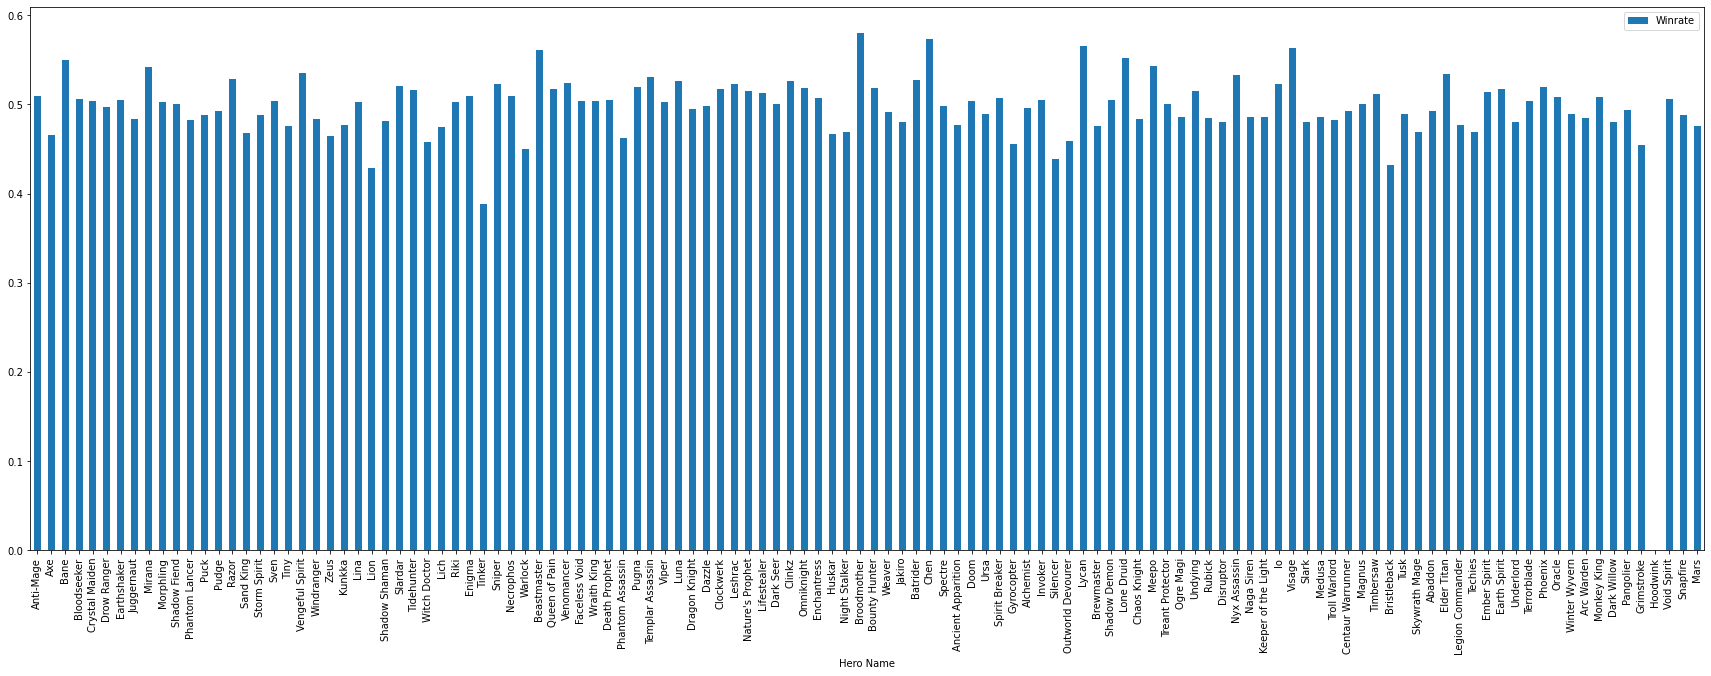

In [127]:
df_heroes_with_score.plot.bar(figsize=(30,10), x='Hero Name', y='Winrate', rot=90)

In [128]:
df_heroes_with_score_sorted = df_heroes_with_score.sort_values(by=['Winrate'])
df_heroes_with_score_smallest = df_heroes_with_score.nsmallest(10, 'Winrate')
df_heroes_with_score_greatest = df_heroes_with_score.nlargest(10, 'Winrate')

<AxesSubplot:xlabel='Hero Name'>

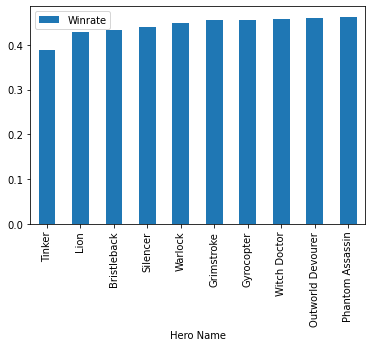

In [130]:
df_heroes_with_score_smallest.plot.bar(x='Hero Name', y='Winrate', rot=90)

<AxesSubplot:xlabel='Hero Name'>

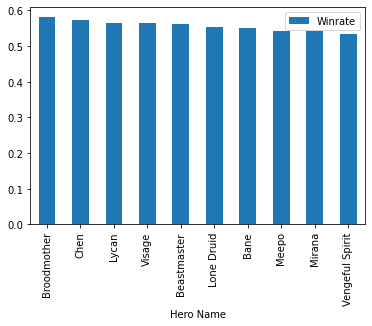

In [131]:
df_heroes_with_score_greatest.plot.bar(x='Hero Name', y='Winrate', rot=90)

<AxesSubplot:xlabel='Number Picks', ylabel='Winrate'>

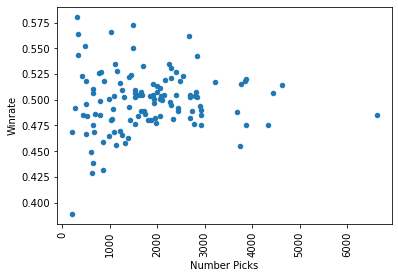

In [135]:
df_heroes_with_score.plot.scatter(x='Number Picks', y='Winrate', rot=90)